# GenAI - Anthropic on Vertex

---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [21]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.storage', 'google-cloud-storage'),
    ('google.cloud.bigquery', 'google-cloud-bigquery'),
    ('anthropic[vertex]', 'anthropic[vertex]'),
    ('httpx', 'httpx')
]

import importlib
install = False
for package in packages:
    !pip install {package[1]} -U -q
    '''
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q
    '''

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
vertexai 1.71.1 requires google-cloud-aiplatform[all]==1.71.1, but you have google-cloud-aiplatform 1.84.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-google-vertexai 2.0.13 requires google-cloud-storage<3.0.0,>=2.18.0, but you have google-cloud-storage 3.1.0 which is incompatible.
google-cloud-aiplatform 1.84.0 requires google-cloud-storage<3.0.0dev,>=1.32.0, but you have google-cloud-storage 3.1.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-aiplatform 1.84.0 requires google-cloud-storage

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [22]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'mg-ce-demos'

In [2]:
REGION = 'us-east5'

# Set the BUCKET name for saving work:
BUCKET = PROJECT_ID

packages:

In [3]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage

import anthropic
from anthropic import AnthropicVertex

import json
import io
import base64
import asyncio
import httpx
import requests
import IPython
from IPython.display import Image
import datetime, time

In [4]:
anthropic.__version__

'0.49.0'

clients:

In [5]:
anthropic_client = AnthropicVertex(region=REGION, project_id=PROJECT_ID)
gcs = storage.Client(project = PROJECT_ID)
bq = bigquery.Client(project = PROJECT_ID)

bucket = gcs.lookup_bucket(BUCKET)

In [11]:
# Anthropic Model(s)
anthr_claude_sonnet37 = "claude-3-7-sonnet@20250219"

## Code

### Text Prompts

#### Complete response

In [12]:
prompt = "What is artificial intelligence?"

In [13]:
response_text_complete = anthropic_client.messages.create(
    max_tokens=2048,
    messages=[
        {
            "role": "user",
            "content": prompt,
        }
    ],
    model=anthr_claude_sonnet37,
)
#print(response_text_complete.model_dump_json(indent=2))

In [14]:
#print(response_text_complete.content[0].text)
IPython.display.Markdown(response_text_complete.content[0].text)

Artificial intelligence (AI) refers to computer systems designed to perform tasks that typically require human intelligence. These include learning from experience, recognizing patterns, understanding language, solving problems, and making decisions.

AI encompasses various approaches, from rule-based systems to modern machine learning methods like neural networks. It can be categorized as narrow AI (specialized for specific tasks) or general AI (hypothetical systems with human-like intelligence across domains).

Modern AI applications include virtual assistants, recommendation systems, image recognition, autonomous vehicles, and language models like the one powering our conversation right now.

#### Streaming response

In [15]:
with anthropic_client.messages.stream(
    max_tokens=2048,
    messages=[
        {
            "role": "user",
            "content": prompt,
        }
    ],
    model=anthr_claude_sonnet37,
) as stream:
    for text in stream.text_stream:
        print(text, end="", flush=True)

Artificial intelligence (AI) refers to computer systems designed to perform tasks that typically require human intelligence. These include learning from experience, recognizing patterns, understanding language, making decisions, and solving problems.

 rule-based systems to modern machine learning techniques like neural networks. It can be narrow (specialized for specific tasks) or aimed toward more general capabilities.

 computer science with data, statistics, psychology, linguistics, and other disciplines to create systems that can process information and respond intelligently to their environment.

### Image Prompts

#### Complete response

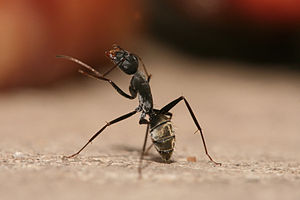

In [16]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a7/Camponotus_flavomarginatus_ant.jpg/300px-Camponotus_flavomarginatus_ant.jpg"
image_media_type = "image/jpeg"
image_b64 = base64.b64encode(httpx.get(image_url).content).decode("utf-8")

response = requests.get(image_url)
image = Image(response.content, width=300, height=200)

image

In [17]:
response_image_complete = anthropic_client.messages.create(
    max_tokens=2048,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": image_media_type,
                        "data": image_b64,
                    },
                },
                {"type": "text", "text": "Describe this image."},
            ],
        }
    ],
    model=anthr_claude_sonnet37,
)
#print(response_image_complete.model_dump_json(indent=2))

In [18]:
#print(response_image_complete.content[0].text)
IPython.display.Markdown(response_image_complete.content[0].text)

The image shows a close-up photograph of an ant on a textured surface. The ant is captured in sharp detail, displaying its characteristic slender body with three distinct segments (head, thorax, and abdomen), long thin legs, and antennae. The ant appears to be carrying something, possibly food or material for the colony. The background is blurred, creating a shallow depth of field that emphasizes the ant while showing a warm-toned, soft-focus environment. This macro photography nicely highlights the intricate details of the ant's anatomy and posture as it goes about its activities.

#### Streaming response

In [19]:
with anthropic_client.messages.stream(
    max_tokens=2048,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": image_media_type,
                        "data": image_b64,
                    },
                },
                {"type": "text", "text": "Describe this image."},
            ],
        }
    ],
    model=anthr_claude_sonnet37,
) as stream:
    for text in stream.text_stream:
        print(text, end="", flush=True)

The image shows a black ant in close-up detail. The ant is standing on what appears to be a textured surface, possibly concrete or stone. Its slender body, segmented form, and thin legs are clearly visible, showcasing the characteristic ant anatomy. The ant appears to be carrying something small in its mandibles, which is common behavior as ants often transport food or materials back to their colony. The background is softly blurred, creating a shallow depth of field that keeps the focus on the ant itself. The photograph captures the impressive strength and determined nature of these fascinating insects that can carry items many times their own body weight.

### App examples

#### Streamlit example - simple chatbot

In [77]:
%%writefile claudeonvertex.py

import streamlit as st
import anthropic
from anthropic import AnthropicVertex

PROJECT_ID = 'mg-ce-demos'
REGION = 'us-east5'

# Anthropic Vertex Client
anthropic_client = AnthropicVertex(region=REGION, project_id=PROJECT_ID)

# Anthropic Model
anthr_claude_sonnet37 = "claude-3-7-sonnet@20250219"

# Initialize session state for conversation history
if "messages" not in st.session_state:
    st.session_state.messages = []

# Function to get response from Claude
def get_claude_response(prompt):
    try:
        response = anthropic_client.messages.create(
            model=anthr_claude_sonnet37,
            max_tokens=1024,
            temperature=0.5,
            system = "",
            messages = st.session_state.messages
        )
        return response.content[0].text
    except Exception as e:
        return f"An error occurred: {str(e)}"

# Streamlit app
st.markdown("<h1 style='color:firebrick'>Claude on Vertex Chatbot</h1>",unsafe_allow_html=True)

# Display chat messages
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.write(message["content"])

# Chat input
if prompt := st.chat_input("What would you like to ask Claude?"):
    # Add user message to chat history
    st.session_state.messages.append({"role": "user", "content": prompt})
    with st.chat_message("user"):
        st.write(prompt)

    # Get Claude's response
    with st.chat_message("assistant"):
        message_placeholder = st.empty()
        full_response = get_claude_response(prompt)
        message_placeholder.write(full_response)
    
    # Add Claude's response to chat history
    st.session_state.messages.append({"role": "assistant", "content": full_response})

# Sidebar with information

with st.sidebar:
    st.markdown("# <div style='color:firebrick'>About</div>",unsafe_allow_html=True)
    st.markdown("### A simple chatbot using the Anthropic API to interact with Claude.")
    st.markdown("""<div style='color:darkslategrey;font-size:smaller'>
    The app demonstrates basic usage of Streamlit for creating interactive chat interfaces.<br/>
    We are using version 3.5 of Claude Sonnet, which is in the misddle of the Claude range.<br/>
    The other Claude models are Haiku, (less capable but cheaper version), and Opus (more expensive and more powerful).</div>""",
    unsafe_allow_html=True
    )

Writing claudeonvertex.py
